# Starry night Dataset Example

TODO: introduction to the dataset - for now see AER1513 assignment 3

In [1]:
import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

from pylgmath import so3op, se3op, Transformation
from pysteam import state, evaluator, problem, solver

In [2]:
data = loadmat("starry_night_dataset.mat")

# total number of states
K = data["t"].shape[-1]

# stereo camera intrinsics and extrinsics
f_u, f_v, c_u, c_v, b = data["fu"][0, 0], data["fv"][0, 0], data["cu"][0, 0], data["cv"][0, 0], data["b"][0, 0]
C_cv, rho_cv_inv = data["C_c_v"], data["rho_v_c_v"]
T_cv = se3op.Cr2T(C_ab=C_cv, r_ab_inb=rho_cv_inv)

# ground truth states (i.e. poses) as (K, 4, 4) array
r_vi_ini = data["r_i_vk_i"].T[..., None]
C_vi = so3op.vec2rot(data["theta_vk_i"].T[..., None]).swapaxes(-1, -2)
T_vi = se3op.Cr2T(C_ab=C_vi, r_ab_inb=r_vi_ini)

# velocity measurements (considered as inputs) as (K, 6, 1) array
v_vi_inv, w_vi_inv = data["v_vk_vk_i"].T, data["w_vk_vk_i"].T
varpi_iv_inv = np.concatenate([-v_vi_inv, -w_vi_inv], axis=-1)[..., None]

# velocity measurement dt as (K,) array where dt[k] = t_k - t_k-1, note that dt[0] is invalid
t = data["t"].squeeze()
dt = t - np.roll(t, 1)

# velocity information matrices as (K, 6, 6) array
v_var, w_var = data["v_var"], data["w_var"]
v_var_inv = np.reciprocal(v_var.squeeze())
w_var_inv = np.reciprocal(w_var.squeeze())
Q_inv = np.zeros((K, 6, 6))
Q_inv[..., :, :] = spla.block_diag(np.diag(v_var_inv), np.diag(w_var_inv))
Q_inv = Q_inv / (dt[..., None, None]**2)  # divided by dt^2

# landmark positions in inertial frame
rho_pi_ini = data["rho_i_pj_i"].T[..., None]  # raw feature positions as (20, 3, 1) array in inertial frame
padding = np.ones(rho_pi_ini.shape[:-2] + (1,) + rho_pi_ini.shape[-1:])  # add a 1 padding to convert to homo. points
rho_pi_ini = np.concatenate((rho_pi_ini, padding), axis=-2)  # feature positions as (20, 4, 1) array homo. points

# landmark measurements (considered as observations)
y_k_j = data["y_k_j"].transpose((1, 2, 0))[..., None]  # measurements as (K, 20, 4, 1) array
y_mask = np.where(y_k_j == -1, 0, 1)[..., 0, 0]  # measurement mask as (K, 20) array, 0 if measurement is invalid

# landmark measurement covariances as (K, 20, 4, 4) array
y_var = data["y_var"]
y_var_inv = np.reciprocal(y_var.squeeze())
R_inv = np.diag(y_var_inv)


In [3]:
# Initialization using inputs
k1, k2 = 1215, 1715  # [1215, 1715)

hat_T_vi = np.copy(T_vi)
hat_P = np.tile(np.eye(6) * 1e-4, (K, 1, 1))

for k in range(k1 + 1, k2):
  hat_T_vi[k] = se3op.vec2tran(dt[k] * varpi_iv_inv[k - 1]) @ hat_T_vi[k - 1]  # possion equation

  F = se3op.vec2jacinv(dt[k] * varpi_iv_inv[k - 1])
  hat_P[k] = F @ hat_P[k - 1] @ F.T + npla.inv(Q_inv[k])

In [4]:
# Optimize

# Set up state variables with initial conditions
# note: Transformation constructor always copies the input value, while TransformStateVar simply wraps a Transformation
# without copying.
T_vi_vars = [state.TransformStateVar(Transformation(T_ba=hat_T_vi[k])) for k in range(k1, k2)]

# Set up cost terms
cost_terms = []
# use a shared L2 loss function for all cost terms
loss_func = problem.L2LossFunc()

# construct velocity measurement (input) cost terms
for k in range(k1 + 1, k2):
  noise_model = problem.StaticNoiseModel(Q_inv[k], "information")
  meas = Transformation(T_ba=se3op.vec2tran(dt[k] * varpi_iv_inv[k - 1]))
  error_func = evaluator.TransformErrorEval(meas_T_21=meas, T_10=T_vi_vars[k - 1 - k1], T_20=T_vi_vars[k - k1])
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))
# construct landmark measurement (observation) cost terms
intrinsics = evaluator.CameraIntrinsics(f_u, f_v, c_u, c_v, b)
T_cv_var = evaluator.FixedTransformEvaluator(Transformation(T_ba=T_cv))
noise_model = problem.StaticNoiseModel(R_inv, "information")
for k in range(k1, k2):
  for l in range(rho_pi_ini.shape[0]):
    if y_mask[k, l] == 0:
      continue
    landmark = state.LandmarkStateVar(rho_pi_ini[l], is_locked=True)
    T_vi_k = evaluator.TransformStateEvaluator(T_vi_vars[k - k1])
    T_ci_k = evaluator.ComposeTransformEvaluator(T_cv_var, T_vi_k)
    error_func = evaluator.StereoCameraErrorEval(y_k_j[k, l], intrinsics, T_ci_k, landmark)
    cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

# construct the optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_cost_term(*cost_terms)
opt_prob.add_state_var(*T_vi_vars)

# construct the solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True, use_sparse_matrix=False)
print("Reached here")
optimizer.optimize()

# copy values back
for i, k in enumerate(range(k1, k2)):
  hat_T_vi[k] = T_vi_vars[i].get_value().matrix()

# copy covariance
full_hat_P = optimizer.query_covariance()
hat_P[k1:k2] = np.array([full_hat_P[i * 6:(i + 1) * 6, i * 6:(i + 1) * 6] for i in range(int(full_hat_P.shape[0] / 6))])

Reached here
Begin Optimization
------------------
Number of States:  500
Number of Cost Terms:  2258
Initial Cost:  1752504.5243635105
Iteration:    1  -  Cost: 233339.7208
Iteration:    2  -  Cost:  2233.9233
Iteration:    3  -  Cost:   524.8120
Iteration:    4  -  Cost:   519.7981
Iteration:    5  -  Cost:   519.7964
Termination Cause:  CONVERGED RELATIVE CHANGE
Total Optimization Time: 7.6597 seconds


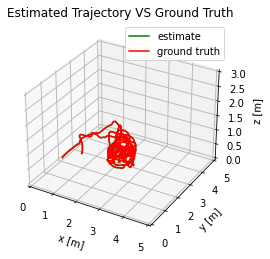

In [5]:
C_vi, r_iv_inv = se3op.T2Cr(T_ab=T_vi)
r_vi_ini = -C_vi.swapaxes(-2, -1) @ r_iv_inv
hat_C_vi, hat_r_iv_inv = se3op.T2Cr(T_ab=hat_T_vi)
hat_r_vi_ini = -hat_C_vi.swapaxes(-2, -1) @ hat_r_iv_inv

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(hat_r_vi_ini[:, 0, 0], hat_r_vi_ini[:, 1, 0], hat_r_vi_ini[:, 2, 0], c='g', label='estimate')
ax.plot(r_vi_ini[:, 0, 0], r_vi_ini[:, 1, 0], r_vi_ini[:, 2, 0], c='r', label='ground truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_xlim3d(0, 5)
ax.set_ylim3d(0, 5)
ax.set_zlim3d(0, 3)
ax.set_title("Estimated Trajectory VS Ground Truth")
ax.legend()

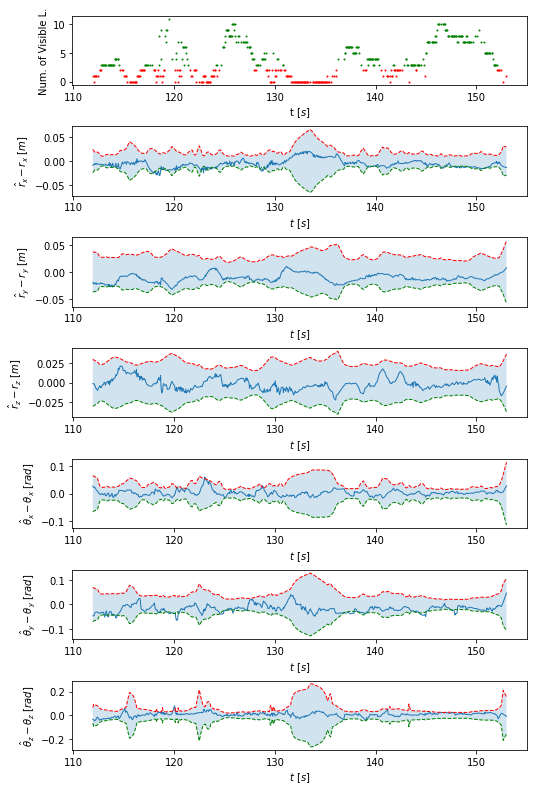

In [6]:
C_vi, r_iv_inv = se3op.T2Cr(T_ab=T_vi)
r_vi_ini = -C_vi.swapaxes(-2, -1) @ r_iv_inv
hat_C_vi, hat_r_iv_inv = se3op.T2Cr(T_ab=hat_T_vi)
hat_r_vi_ini = -hat_C_vi.swapaxes(-2, -1) @ hat_r_iv_inv

eye = np.zeros_like(C_vi)
eye[..., :, :] = np.eye(3)
rot_err = so3op.hatinv(eye - hat_C_vi @ npla.inv(C_vi))
trans_err = hat_r_vi_ini - r_vi_ini

ts = t[k1:k2]
stds = (np.sqrt(np.diag(full_hat_P))).reshape((-1, 6))

# plot landmarks for reference
num_meas = np.sum(y_mask[k1:k2, :], axis=-1)
green = np.argwhere(num_meas >= 3)
red = np.argwhere(num_meas < 3)

fig = plt.figure()

plot_number = 711
fig.set_size_inches(8, 12)
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.6)

ax = fig.add_subplot(plot_number)
ax.scatter(ts[green], num_meas[green], s=1, c='g')
ax.scatter(ts[red], num_meas[red], s=1, c='r')
ax.set_xlabel(r't [$s$]')
ax.set_ylabel(r'Num. of Visible L.')

labels = ['x', 'y', 'z']
for i in range(3):
  ax = fig.add_subplot(plot_number + 1 + i)
  ax.plot(ts, trans_err[k1:k2, i].flatten(), '-', linewidth=1.0)
  ax.plot(ts, 3 * stds[:, i], 'r--', linewidth=1.0)
  ax.plot(ts, -3 * stds[:, i], 'g--', linewidth=1.0)
  ax.fill_between(ts, -3 * stds[:, i], 3 * stds[:, i], alpha=0.2)
  ax.set_xlabel(r"$t$ [$s$]")
  ax.set_ylabel(r"$\hat{r}_x - r_x$ [$m$]".replace("x", labels[i]))
for i in range(3):
  ax = fig.add_subplot(plot_number + 4 + i)
  ax.plot(ts, rot_err[k1:k2, i].flatten(), '-', linewidth=1.0)
  ax.plot(ts, 3 * stds[:, 3 + i], 'r--', linewidth=1.0)
  ax.plot(ts, -3 * stds[:, 3 + i], 'g--', linewidth=1.0)
  ax.fill_between(ts, -3 * stds[:, 3 + i], 3 * stds[:, 3 + i], alpha=0.2)
  ax.set_xlabel(r"$t$ [$s$]")
  ax.set_ylabel(r"$\hat{\theta}_x - \theta_x$ [$rad$]".replace("x", labels[i]))